In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from itertools import chain
from collections import Counter
from PIL import Image
from tqdm import tqdm
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models.resnet import resnet18 
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
seed = 17167055
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
root = 'dataset'
dataset = [str(data) for data in list(chain(*[i.glob('*') for i in Path(root).glob('*')]))]
print(f'Total data: {len(dataset)}')

Total data: 4092


In [4]:
def img_loader(path):
    with open(path, 'rb') as f:
        return Image.open(f).convert('RGB')

In [5]:
images = [img_loader(i) for i in dataset]
labels = [i.split('\\')[-2] for i in dataset]

assert len(images)==len(labels)
assert len(images)==len(dataset)

In [6]:
scaler = LabelEncoder()
labels = scaler.fit_transform(labels)

In [7]:
Counter(labels).most_common()

[(0, 2162), (1, 1930)]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=seed)
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')

Train: 2454
Validation: 819
Test: 819


In [9]:
class MaskDataset(Dataset):
    def __init__(self, X, y, transform):
        self.image = X
        self.label = y
        self.transform = transform
        
    def __getitem__(self, idx):
        img = self.image[idx]
        lbl = self.label[idx]
        if self.transform:
            img = self.transform(img)
        return img, lbl
    
    def __len__(self):
        return len(self.image)

In [10]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(2),
    transforms.ToTensor(),
])

transform_valtest = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [11]:
trainset = MaskDataset(X_train, y_train, transform_train)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

valset = MaskDataset(X_val, y_val, transform_valtest)
valloader = DataLoader(valset, batch_size=1, shuffle=False)

testset = MaskDataset(X_test, y_test, transform_valtest)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
net = resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2, bias=True)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
n_epochs = 50
scheduler = CosineAnnealingLR(optimizer, n_epochs)

In [14]:
def train(epoch, trainloader, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc='Training')
    for batch_idx, (x_train, y_train) in enumerate(pbar):
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = net(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_train.size(0)
        correct += predicted.eq(y_train.data).cpu().sum()
        pbar.set_postfix({"epoch":(epoch), "loss":(train_loss/(batch_idx+1)), "acc":(100.*correct/total).item()})
    lr_.append(scheduler.get_last_lr())
    acc = 100.*correct/total
    loss = train_loss/(batch_idx+1)
    return acc, loss

In [15]:
def valid(epoch, loader, net):
    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader,desc='Validating')
    with torch.no_grad():
        for batch_idx, (x_val, y_val) in enumerate(pbar):
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = net(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += predicted.eq(y_val.data).cpu().sum()
            pbar.set_postfix({"epoch":(epoch), "loss":(val_loss/(batch_idx+1)), "acc":(100.*correct/total).item()})
    acc = 100.*correct/total
    loss = val_loss/(batch_idx+1)
    return acc, loss

In [16]:
best_acc = 0.0
train_acc_ = []
train_loss_ = []
valid_acc_ = []
valid_loss_ = []
epoch_ = []
lr_ = []
for epoch in range(n_epochs):
    train_acc, train_loss = train(epoch, trainloader, net)
    val_acc, val_loss = valid(epoch, valloader, net)
    train_acc_.append(train_acc)
    train_loss_.append(train_loss)
    valid_acc_.append(val_acc)
    valid_loss_.append(val_loss)
    scheduler.step()
    if (val_acc > best_acc):
        best_acc = val_acc
        print(f'Best acc: {best_acc:.4f}, saving...')
        torch.save(net, f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_resnet18_{best_acc:.4f}_epoch_{epoch}.pth')
        epoch_.append(epoch)

Training:   1%|▌                                        | 2/154 [00:00<00:08, 17.62it/s, epoch=1, loss=0.487, acc=78.1]

Best acc: 93.5287, saving...


Training:   1%|▌                                        | 2/154 [00:00<00:08, 17.99it/s, epoch=3, loss=0.159, acc=90.6]

Best acc: 94.9939, saving...


Training:   1%|▌                                        | 2/154 [00:00<00:09, 16.27it/s, epoch=4, loss=0.185, acc=90.6]

Best acc: 97.1917, saving...


Training:   1%|▌                                        | 2/154 [00:00<00:08, 17.44it/s, epoch=7, loss=0.199, acc=96.9]

Best acc: 98.4127, saving...


Training:   1%|▌                                       | 2/154 [00:00<00:08, 18.40it/s, epoch=10, loss=0.167, acc=90.6]

Best acc: 99.1453, saving...


Training:   1%|▌                                       | 2/154 [00:00<00:08, 16.89it/s, epoch=17, loss=0.189, acc=87.5]

Best acc: 99.2674, saving...


Training:   1%|▌                                       | 2/154 [00:00<00:08, 17.15it/s, epoch=22, loss=0.155, acc=96.9]

Best acc: 99.6337, saving...


Training:   1%|▌                                      | 2/154 [00:00<00:09, 16.41it/s, epoch=39, loss=0.0438, acc=96.9]

Best acc: 99.7558, saving...


Validating: 100%|██████████████████████████████████| 819/819 [00:06<00:00, 128.12it/s, epoch=49, loss=0.0105, acc=99.8]


In [17]:
print(f'train_acc: {train_acc:.2f}')
print(f'val_acc: {val_acc:.2f}')
model_path = f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_resnet18_{train_acc:.2f}_{val_acc:.2f}_last.pth'
print(f'last model path: {model_path}')
torch.save(net, model_path)

train_acc: 97.92
val_acc: 99.76
last model path: models/21052021_155503_resnet18_97.92_99.76_last.pth


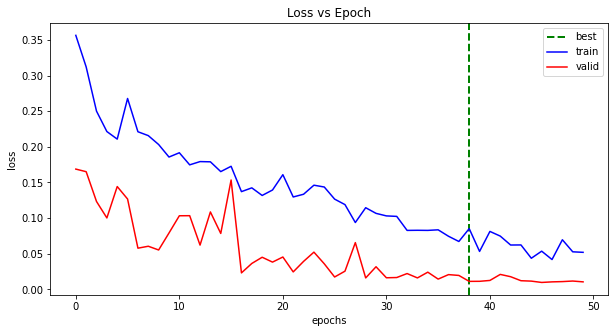

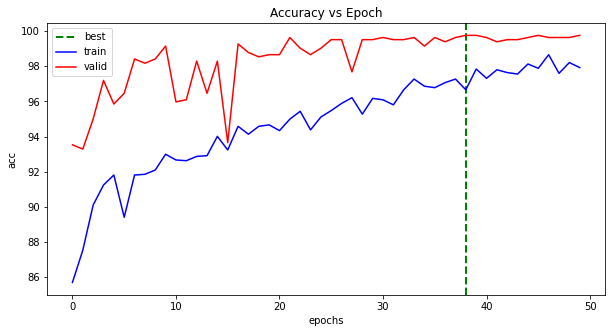

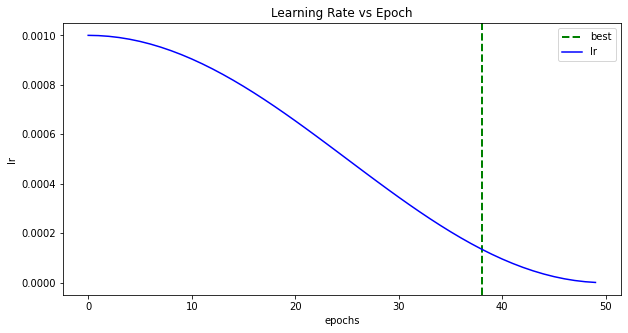

In [18]:
plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_loss_, 'b', label='train')
plt.plot(range(n_epochs), valid_loss_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_acc_, 'b', label='train')
plt.plot(range(n_epochs), valid_acc_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), lr_, 'b', label='lr')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.title('Learning Rate vs Epoch')
plt.legend()
plt.show()

In [19]:
# the true (rows), predicted (columns)

def evaluate_test(model_path):
    net = torch.load(model_path, map_location=device)
    net.eval()
    pbar = tqdm(testloader, desc='Evaluating')
    y = list()
    y_hat = list()
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(pbar):
            image = image.to(device)
            y.append(label.item())
            output = net(image)
            _, predicted = torch.max(output.data, 1)
            y_hat.append(predicted.item())
    print(classification_report(y, y_hat))
    print(confusion_matrix(y_true=y, y_pred=y_hat))

best_model_path = 'models/21052021_155157_resnet18_99.7558_epoch_38.pth'
evaluate_test(best_model_path)

last_model_path = 'models/21052021_155503_resnet18_97.92_99.76_last.pth'
evaluate_test(last_model_path)

Evaluating:   1%|▉                                                                   | 11/819 [00:00<00:07, 106.19it/s]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       433
           1       0.99      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819

[[431   2]
 [  5 381]]


Evaluating: 100%|███████████████████████████████████████████████████████████████████| 819/819 [00:05<00:00, 148.15it/s]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       433
           1       0.99      0.98      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819

[[430   3]
 [  6 380]]
